# Voronoi cells of circles

In [22]:
import itertools
import random
from geometry.circle import Circle
from geometry.coord import Coord
from geometry.polygon import Polygon
import numpy as np
import shapely
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import polygonize,unary_union
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from scipy.spatial import voronoi_plot_2d
from shapely.ops import voronoi_diagram
import matplotlib.pyplot as plt
from environment.environment import Environment
from typing import Dict
from typing import List
import networkx as nx
from geometry.path import Path
from algorithms.single_threat import single_threat_shortest_path_with_budget_constraint

In [3]:
circles = [Circle(Coord(100, 100), 50), Circle(Coord(200, 300), 100), Circle(Coord(300, 60), 50), Circle(Coord(400, 100), 50), Circle(Coord(500, 500), 100), Circle(Coord(600, 250), 50), Circle(Coord(380, 300), 50), Circle(Coord(300, 200), 25)]

In [4]:
world = Polygon([Coord(0, 0), Coord(0, 700), Coord(700, 700), Coord(700, 0)])

(-35.0, 735.0, -35.0, 735.0)

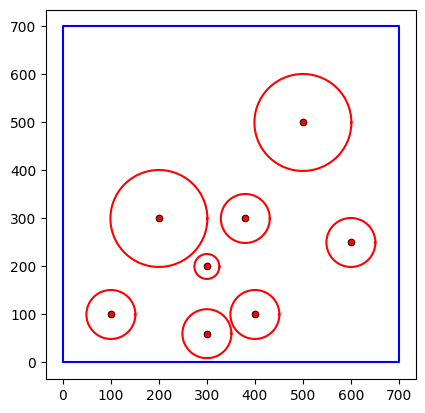

In [5]:
world.plot()
for circle in circles:
    circle.plot()
plt.axis('scaled')

# approximation by centers

In [78]:
centers = [circle.center for circle in circles]

In [79]:
def circle_to_boundary_points(centers: List[Coord]) -> Dict:
    centers_boundary_points = {c: None for c in centers}

    regions = voronoi_diagram(MultiPoint([center.xy for center in centers]))
    intersected_polygons = [polygon.intersection(world.to_shapely) for polygon in regions.geoms]
    intersected_polygons = [Polygon.polygon_from_shapely(polygon) for polygon in intersected_polygons]

    for center in centers:
        for polygon in intersected_polygons:
            if polygon.contains(center):
                centers_boundary_points[center] = polygon.linsplit_by_distance(3)
                break

    return centers_boundary_points

In [80]:
centers_boundary_points = circle_to_boundary_points(centers)

In [ ]:
for center, boundary in centers_boundary_points.items():
    for point in boundary:
        point.plot(color='green')
    for circle in circles:
        circle.plot()
plt.axis('scaled')

(-35.0, 735.0, -35.00000000000003, 735.0)

Error in callback <function flush_figures at 0x0000021EF41A3D30> (for post_execute):


# end to end path computation

In [82]:
source = Coord(1, 1)
target = Coord(699, 699)

random.seed(43)

all_circles = Environment.create_disjoint_circles_in_range(source, target, num_circles=3, env_range=(700,700))
# filtered_circles = Environment.filter_circles(source, target, all_circles)
environment = Environment(source, target, all_circles)

In [83]:
world

Polygon([Coord(0,0), Coord(0,700), Coord(700,700), Coord(700,0)])

In [ ]:
environment.plot()

Error in callback <function _draw_all_if_interactive at 0x0000021EED8DAF70> (for post_execute):


In [20]:
center_to_circle = {circle.center: circle for circle in all_circles}

In [19]:
center_to_boundary = circle_to_boundary_points([c.center for c in all_circles])

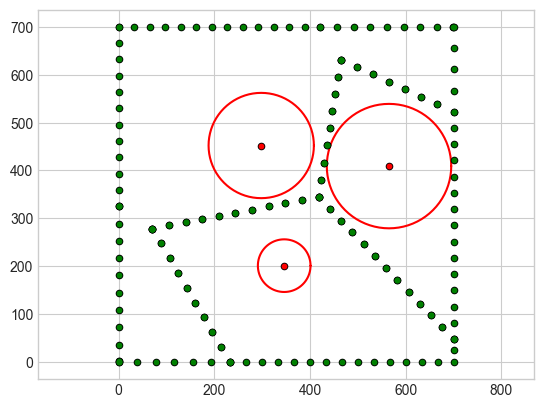

In [14]:
environment.plot()
for center in center_to_boundary:
    for p in center_to_boundary[center]:
        p.plot()

In [71]:
g = nx.Graph()

In [72]:
for center in center_to_boundary:
    for p1, p2 in itertools.combinations(center_to_boundary[center], 2):
        path, length, risk = single_threat_shortest_path_with_budget_constraint(p1, p2, center_to_circle[center], budget=120)
        g.add_edge(p1, p2, length=length, path=path)

c:\users\fogle\pycharmprojects\quick-and-safe\venv\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [73]:
for p in center_to_boundary[source]:
    g.add_edge(source, p, length=source.distance_to(p), path=Path([source, p]))

for p in center_to_boundary[target]:
    g.add_edge(p, target, length=target.distance_to(p), path=Path([p, target]))

In [74]:
path_coords = nx.shortest_path(g, source, target, weight='length')

In [75]:
joint_path = Path([])
for c1, c2 in zip(path_coords[:-1], path_coords[1:]):
    joint_path = Path.concat_paths(joint_path, g[c1][c2]['path'])

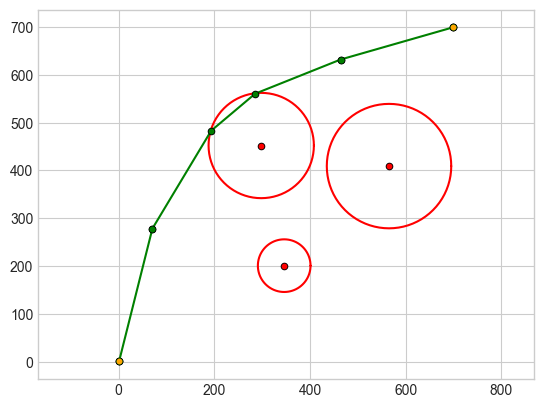

In [77]:
environment.plot()

joint_path.plot()

plt.savefig('voronoi_solution2.png')

# approximation by extreme coords of circle

In [11]:
candidates_of_circle = {circle: circle.linsplit_by_distance(50) for circle in circles}

In [12]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [13]:
all_extreme = [Coord(*c.xy) for c in flatten(candidates_of_circle.values())]

In [16]:
regions = voronoi_diagram(MultiPoint([c.xy for c in flatten(candidates_of_circle.values())]), envelope=world.to_shapely).geoms
candidate_to_region = {candidate: region for candidate, region in zip(flatten(candidates_of_circle.values()), regions)}

In [17]:
# candidate_to_region

In [18]:
from shapely.ops import cascaded_union

united_regions = []
for circle in circles:
    united_regions.append(cascaded_union([candidate_to_region[candidate] for candidate in candidates_of_circle[circle]]))

C:\Users\fogle\AppData\Local\Temp\ipykernel_2364\3245654469.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  united_regions.append(cascaded_union([candidate_to_region[candidate] for candidate in candidates_of_circle[circle]]))


GEOSException: TopologyException: unable to assign free hole to a shell at 96.001776330640681 196.00177633064078

In [ ]:
intersected_polygons = regions
# intersected_polygons = [polygon.intersection(world.to_shapely) for polygon in regions.geoms]

In [94]:
print(intersected_polygons.geoms)

(0.0, 700.0)

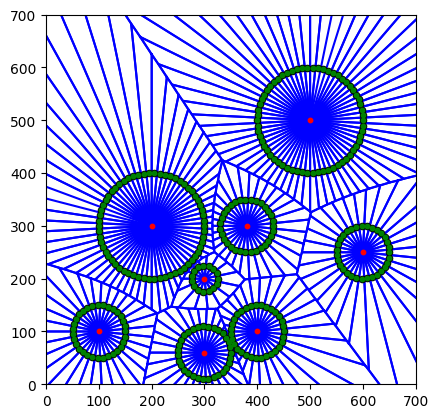

In [95]:
# %matplotlib qt
%matplotlib inline

for polygon in intersected_polygons.geoms:
    try:
        x,y = polygon.exterior.xy
        plt.plot(x, y, color='blue')
        # linsplit_points = Polygon.polygon_from_shapely(polygon).linsplit_by_distance(30)
        # for point in linsplit_points:
        #     point.plot(color='green')
    except:
        pass

for coord in all_extreme:
    coord.plot()
for circle in circles:
    circle.plot()
plt.axis('scaled')
plt.xlim(0, 700)
plt.ylim(0, 700)

# naive computation

In [10]:
circle_halfspaces = {circle: [] for circle in circles}

In [11]:
for circle1 in circle_halfspaces:
    for circle2 in circle_halfspaces:
        if circle1 == circle2:
            continue

        circle_halfspaces[circle1].append(Circle.calculate_halfspace_between_circles(circle1, circle2, world=world))

In [25]:
colors = ['blue', 'red', 'orange', 'green', 'teal', 'gray', 'purple', 'pink', 'cyan', 'brown', 'navy', 'thistle', 'gold', 'lightgreen', 'beige']

(-35.0, 735.0, -35.0, 735.0)

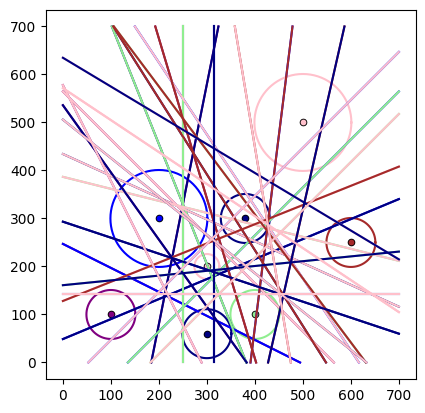

In [26]:
from random import choice

for circle in circle_halfspaces:
    color = choice(colors)

    circle.plot(color=color)
    for line in circle_halfspaces[circle]:
        line.plot(color=color)

plt.axis('scaled')

(-32.550000000000004, 683.55, -35.0, 735.0)

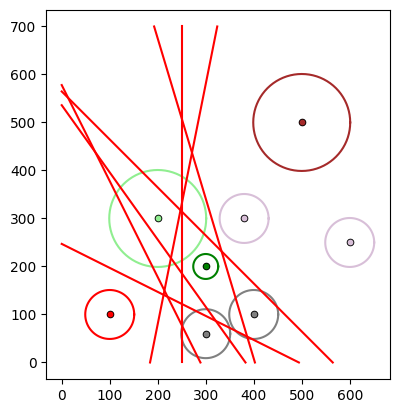

In [27]:
from random import choice

color = choice(colors)

circles[0].plot(color=color)

for line in circle_halfspaces[circles[0]]:
    line.plot(color=color)

for circle in circles[1:]:
    color = choice(colors)

    circle.plot(color=color)

plt.axis('scaled')

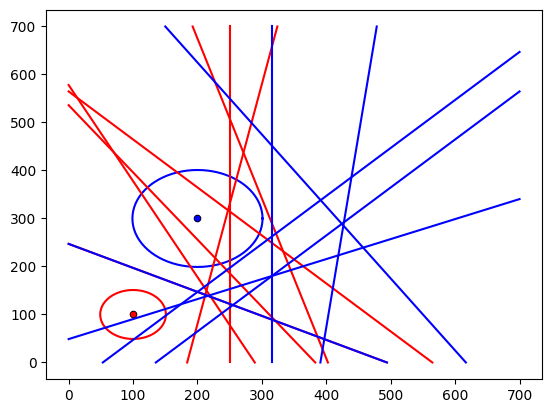

In [14]:
for line in circle_halfspaces[circles[0]]:
    line.plot(color='red')
circles[0].plot(color='red')

for line in circle_halfspaces[circles[1]]:
    line.plot(color='blue')
circles[1].plot(color='blue')